# Fully-Connected Neural Nets
In the previous homework you implemented a fully-connected two-layer neural network on CIFAR-10. The implementation was simple but not very modular since the loss and gradient were computed in a single monolithic function. This is manageable for a simple two-layer network, but would become impractical as we move to bigger models. Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, 
and introduce Dropout as a regularizer to more efficiently optimize deep networks.
  

In [1]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from comp411.classifiers.fc_net import *
from comp411.data_utils import get_CIFAR10_data
from comp411.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from comp411.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Affine layer: forward
Open the file `comp411/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementation by running the following:

In [3]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769849468192957e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [4]:
# Test the affine_backward function
np.random.seed(451)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  1.7000935287071014e-10
dw error:  9.587101251136971e-11
db error:  1.5250434488823124e-11


# ReLU activation: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [5]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU activation: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [6]:
np.random.seed(451)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.275629245991252e-12


## Inline Question 1: 

In addition to ReLU, there are a number of different activation functions that one could use in neural networks, 
each with its pros and cons. In particular, an issue commonly seen with activation functions is getting zero (or close to zero)
 gradient flow during backpropagation. Which of the following activation functions have this problem? If you consider these 
 functions in the one dimensional case, what types of input would lead to this behaviour?
1. Sigmoid
2. ReLU
3. Leaky ReLU

## Answer:
[FILL THIS IN]

# Leaky ReLU activation: forward
To solve the dying ReLU problem, researchers come up with a modified version i.e. Leaky ReLU.
You can read its description from the `Leaky ReLU` section of <http://cs231n.github.io/neural-networks-1/>. 
Now, implement the forward pass for the Leaky ReLU activation function in the `leaky_relu_forward` function.

To test your implementation, use the following:

In [7]:
# Test the leaky relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = leaky_relu_forward(x, {"alpha": 0.001})
correct_out = np.array([[-5.00000000e-04, -4.09090909e-04, -3.18181818e-04, -2.27272727e-04,],
                        [-1.36363636e-04, -4.54545455e-05,  4.54545455e-02,  1.36363636e-01,],
                        [ 2.27272727e-01,  3.18181818e-01,  4.09090909e-01,  5.00000000e-01,]])

# Compare your output with ours. The error should be on the order of e-9
print('Testing leaky_relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing leaky_relu_forward function:
difference:  1.3333333478534103e-09


# Leaky ReLU activation: backward
Now implement the backward pass for the Leaky ReLU activation function in the `leaky_relu_backward` function and test 
your implementation using numeric gradient checking:

In [8]:
np.random.seed(451)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: leaky_relu_forward(x, {"alpha": 0.003})[0], x, dout)

_, cache = leaky_relu_forward(x, {"alpha": 0.003})
dx = leaky_relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing leaky relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing leaky relu_backward function:
dx error:  4.258613251108541e-12


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed
 by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `comp411/layer_utils.py`.
 
For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically
 gradient check the backward pass:

In [9]:
from comp411.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(451)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))


Testing affine_relu_forward and affine_relu_backward:
dx error:  9.3486768025527e-11
dw error:  5.426556449721655e-10
db error:  1.025140345152082e-10


We also implemented the `affine_lrelu_forward` and `affine_lrelu_backward` functions.
You can run the following to numerically gradient check the backward pass:

In [10]:
from comp411.layer_utils import affine_lrelu_forward, affine_lrelu_backward
np.random.seed(451)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
alpha = np.random.random() / 100
dout = np.random.randn(2, 10)

out, cache = affine_lrelu_forward(x, w, b, {"alpha": 0.005})
dx, dw, db = affine_lrelu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_lrelu_forward(x, w, b, {"alpha": 0.005})[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_lrelu_forward(x, w, b, {"alpha": 0.005})[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_lrelu_forward(x, w, b, {"alpha": 0.005})[0], b, dout)

# Relative error should be around e-9 or less
print('Testing affine_lrelu_forward and affine_lrelu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_lrelu_forward and affine_lrelu_backward:
dx error:  1.3470668969570366e-09
dw error:  1.5689293838353435e-09
db error:  1.7146269715759432e-10


# Loss layers: Softmax and SVM
You implemented these loss functions in the last assignment, so we'll give them to you for free here. You should still 
make sure you understand how they work by looking at the implementations in `comp411/layers.py`.

You can make sure that the implementations are correct by running the following:

In [11]:
np.random.seed(451)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be around the order of e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  9.000143027199895
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.3025998662050595
dx error:  8.85360138903831e-09


# Three-layer network
In the previous assignment, you implemented a two-layer neural network in a single monolithic class. Now that you have 
implemented modular versions of the necessary layers, you are ready to implement your network with a modular approach.
However, this time you will implement a three layer network.

Open the file `comp411/classifiers/fc_net.py` and complete the implementation of the `ThreeLayerNet` class. This class 
will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you 
understand the API. You can run the cell below to test your implementation.

In [12]:
np.random.seed(451)
N, D, H, C = 3, 5, (75, 50), 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = ThreeLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
W3_std = abs(model.params['W3'].std() - std)
b3 = model.params['b3']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'
assert W3_std < std / 10, 'Third layer weights do not seem right'
assert np.all(b3 == 0), 'Third layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H[0]).reshape(D, H[0])
model.params['b1'] = np.linspace(-0.1, 0.9, num=H[0])
model.params['W2'] = np.linspace(-0.3, 0.4, num=H[0]*H[1]).reshape(H[0], H[1])
model.params['b2'] = np.linspace(-0.9, 0.1, num=H[1])
model.params['W3'] = np.linspace(-0.3, 0.4, num=H[1]*C).reshape(H[1], C)
model.params['b3'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)

correct_scores = np.array(
    [[60.09345785, 62.35363693, 64.613816,   66.87399508, 69.13417415, 71.39435323, 73.6545323 ],
     [59.63188791, 61.93770366, 64.2435194,  66.54933515, 68.85515089, 71.16096663, 73.46678238],
     [59.17031798, 61.52177039, 63.8732228,  66.22467521, 68.57612763, 70.92758004, 73.27903245]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 9.313138246559005
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 121.43682228904008
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-6 or less
for reg in [0.0, 0.7]:
    print('Running numeric gradient check with reg = ', reg)
    model.reg = reg
    loss, grads = model.loss(X, y)

    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 9.23e-07
W2 relative error: 9.58e-09
W3 relative error: 2.76e-08
b1 relative error: 4.57e-07
b2 relative error: 3.96e-08
b3 relative error: 2.43e-08
Running numeric gradient check with reg =  0.7
W1 relative error: 8.29e-08
W2 relative error: 7.52e-06
W3 relative error: 2.04e-07
b1 relative error: 5.60e-07
b2 relative error: 5.10e-08
b3 relative error: 1.48e-06


# Solver
In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

Open the file `comp411/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver`
 instance to train a `ThreeLayerNet` that achieves at least `50%` accuracy on the validation set after training for 10 epochs.

In [13]:
model = ThreeLayerNet()
solver_instance = None

##############################################################################
# TODO: Use a Solver instance to train a ThreeLayerNet that achieves at least#
# 50% accuracy on the validation set.                                        #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# to get %50 accuracy we need hyperparameter tuning
# we can use grid search or random search for hyperparameter tuning
# using random hyperparameter tuning better than grid search 
# as argued by Bergstra and Bengio in Random Search for Hyper-Parameter Optimization,
# “randomly chosen trials are more efficient for hyper-parameter optimization
# than trials on a grid”. As it turns out, this is also usually easier to implement.

def params(lr: tuple, reg: tuple, hidden: tuple):
    """
    Generates random values for 
    learning rate, regularization and hidden layer dimension.
    
    params:
    lr: tuple, -> (min, max)
    reg: tuple, -> (min, max)
    hidden: tuple, -> (min, max)
    """
    learning_rate    = np.power(10, np.random.uniform(lr[0], lr[1]))
    regularization   = np.power(10, np.random.uniform(reg[0], reg[1]))
    hidden1 = np.random.randint(hidden[0], hidden[1])
    hidden2 = np.random.randint(hidden[0], hidden[1])
    
    return learning_rate, regularization, hidden1, hidden2
    

best_score = -1
best_lr = None
best_reg = None
best_hidden1 = None
best_hidden2 = None
    
i = 0
while True:
    
    # get random parameters for network and solver
    lr, reg, hidden1, hidden2 = params(lr=(-5, -2), reg=(-7, -4), hidden=(50, 200))

    # create neural network with random parameters
    model = ThreeLayerNet(hidden_dim=(hidden1, hidden2), reg=reg)
    
    solver_instance = Solver(model, data,
                        print_every=-1,
                        num_epochs=10,
                        batch_size=256,
                        update_rule='sgd',
                        optim_config={
                          'learning_rate': lr,
                        },
                        lr_decay=0.95,
                        verbose=False
                 )
    
    # train network
    solver_instance.train()
    
    # get train and validation accuracy of network
    train_accuracy = solver_instance.train_acc_history[-1]
    val_accuracy = solver_instance.best_val_acc
    
    if best_score < val_accuracy:
        best_score = val_accuracy
        
        # save best params
        best_lr = lr
        best_reg = reg
        best_hidden1 = hidden1
        best_hidden2 = hidden2
        best_solver  = solver_instance
        
        print("↑", end="")
        print(f"[{i}] [Accuracy: {val_accuracy:.3f}] [lr: {lr:.10f}] [reg: {reg:.10f}] [hidden1: {hidden1:03}] [hidden2: {hidden2:03}] [Loss: {solver_instance.loss_history[-1]:.3f}]")
        
        if best_score > 0.50:
            break
            
    i += 1
        
print()
print(f"[Best] [Accuracy: {best_score:.3f}] [Loss: {best_solver.loss_history[-1]:.3f}] [lr: {best_lr:.10f}] [reg: {best_reg:.10f}] [hidden1: {best_hidden1:03}] [hidden2: {best_hidden2:03}]")

solver_instance = best_solver
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

↑[0] [Accuracy: 0.114] [lr: 0.0000545922] [reg: 0.0000468653] [hidden1: 078] [hidden2: 181] [Loss: 2.303]
↑[1] [Accuracy: 0.210] [lr: 0.0007072988] [reg: 0.0000355066] [hidden1: 197] [hidden2: 076] [Loss: 2.299]
↑[2] [Accuracy: 0.528] [lr: 0.0083692988] [reg: 0.0000058296] [hidden1: 139] [hidden2: 086] [Loss: 1.196]

[Best] [Accuracy: 0.528] [Loss: 1.196] [lr: 0.0083692988] [reg: 0.0000058296] [hidden1: 139] [hidden2: 086]


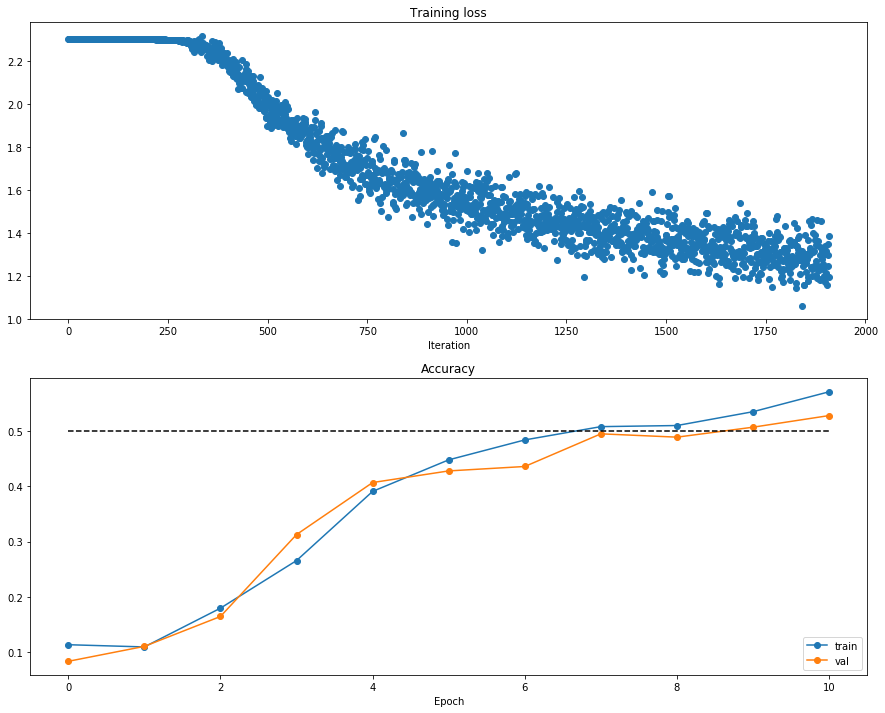

In [14]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver_instance.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver_instance.train_acc_history, '-o', label='train')
plt.plot(solver_instance.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver_instance.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()


# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `comp411/classifiers/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing 
dropout; we will add that feature soon.

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-7 or less.

In [15]:
np.random.seed(451)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
    print('Running check with reg = ', reg)
    model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64, seed=451)

    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)
  
    # Most of the errors should be on the order of e-6 or smaller.   
    # NOTE: It is fine however to see an error for W2 on the order of e-3 with reg=0, and b2 on the order of e-1 with reg=3.14
    # for the check when reg = 0.0
    for name in sorted(grads):
        f = lambda _: model.loss(X, y)[0]
        grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
        print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.3019599371431267
W1 relative error: 9.56e-06
W2 relative error: 3.30e-04
W3 relative error: 4.31e-05
b1 relative error: 8.67e-06
b2 relative error: 9.75e-08
b3 relative error: 1.88e-09
Running check with reg =  3.14
Initial loss:  7.133501465512166
W1 relative error: 8.31e-08
W2 relative error: 4.83e-08
W3 relative error: 3.12e-07
b1 relative error: 3.02e-06
b2 relative error: 1.00e+00
b3 relative error: 1.70e-08


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 20 epochs.

Overfitting with 3 Layers: 
↑[000] [Accuracy: 0.420] [lr: 0.0018299085] [ws: 0.0223092044]


/Users/firattamur/Desktop/fall21/courses/comp411/ComputerVisionDeepLearning/Assignment-2/comp411/classifiers/fc_net.py:340: RuntimeWarning: overflow encountered in multiply
  loss += 0.5 * self.reg * np.sum(np.multiply(w, w))
/Users/firattamur/opt/anaconda3/envs/comp411-v2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/firattamur/Desktop/fall21/courses/comp411/ComputerVisionDeepLearning/Assignment-2/comp411/classifiers/fc_net.py:340: RuntimeWarning: invalid value encountered in double_scalars
  loss += 0.5 * self.reg * np.sum(np.multiply(w, w))
/Users/firattamur/Desktop/fall21/courses/comp411/ComputerVisionDeepLearning/Assignment-2/comp411/layers.py:663: RuntimeWarning: invalid value encountered in subtract
  shifted_logits = x - np.max(x, axis=1, keepdims=True)


↑[010] [Accuracy: 0.880] [lr: 0.0056685934] [ws: 0.0152540946]
↑[012] [Accuracy: 0.920] [lr: 0.0075937360] [ws: 0.0093643530]
↑[091] [Accuracy: 0.940] [lr: 0.0025678298] [ws: 0.0150635022]
↑[165] [Accuracy: 0.980] [lr: 0.0074603933] [ws: 0.0078100295]
↑[345] [Accuracy: 1.000] [lr: 0.0128842415] [ws: 0.0122314275]

[Best] [Accuracy: 1.000] [lr: 0.0128842415] [ws: 0.0122314275]


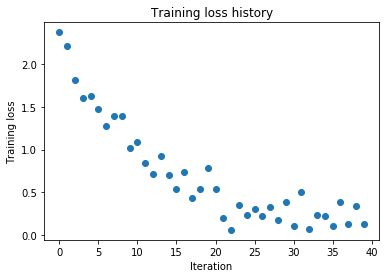

In [16]:
# np.random.seed(451)
# TODO: Use a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale  = 1e-1  # Experiment with this!
learning_rate = 1e-3  # Experiment with this!

def params(lr: tuple, ws: tuple):
    """
    Generates random values for 
    learning rate and weight_scale
    
    params:
    lr: learning rate range tuple, -> (min, max)
    ws: weight scale range  tuple, -> (min, max)
    """
    learning_rate = np.power(10, np.random.uniform(lr[0], lr[1]))
    weight_scale  = np.power(10, np.random.uniform(ws[0], ws[1]))

    return learning_rate, weight_scale

best_train_accuracy = -1
best_solver = None
best_lr = None
best_ws = None

i = 0

print("Overfitting with 3 Layers: ")

while True:
    
    lr, ws = params(lr=(-3, -1), ws=(-3, -1))
    
    model = FullyConnectedNet([100, 100],
              weight_scale=ws, dtype=np.float64)
    solver = Solver(model, small_data,
                    print_every=-1, num_epochs=20, batch_size=25,
                    update_rule='sgd',
                    optim_config={
                      'learning_rate': lr,
                    },
                    verbose=False
             )

    solver.train()
    
    
    train_accuracy = solver.train_acc_history[-1]
    
    if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
        
        best_solver = solver
        best_lr = lr
        best_ws = ws
        
        print("↑", end="")
        print(f"[{i:03}] [Accuracy: {train_accuracy:.3f}] [lr: {lr:.10f}] [ws: {ws:.10f}]")
        
        if train_accuracy == 1.0:
            break
            
    i += 1


print()
print(f"[Best] [Accuracy: {best_train_accuracy:.3f}] [lr: {best_lr:.10f}] [ws: {best_ws:.10f}]")
solver = best_solver

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again, you will have to adjust the learning rate and weight initialization scale, but you should be able to achieve 100% training accuracy within 20 epochs.

Overfitting with 5 Layers: 
↑[000] [Accuracy: 0.080] [lr: 0.0720575000] [ws: 0.3003578906]
↑[002] [Accuracy: 0.160] [lr: 0.0218551426] [ws: 0.0120274714]


/Users/firattamur/Desktop/fall21/courses/comp411/ComputerVisionDeepLearning/Assignment-2/comp411/layers.py:666: RuntimeWarning: invalid value encountered in subtract
  shifted_logits = x - np.max(x, axis=1, keepdims=True)


↑[005] [Accuracy: 0.520] [lr: 0.0626053589] [ws: 0.0355895883]
↑[009] [Accuracy: 0.760] [lr: 0.0304244719] [ws: 0.0389344145]
↑[037] [Accuracy: 0.960] [lr: 0.0113533588] [ws: 0.0423518144]
↑[669] [Accuracy: 1.000] [lr: 0.0300444447] [ws: 0.0352461127]

[Best] [Accuracy: 1.000] [lr: 0.0300444447] [ws: 0.0352461127]


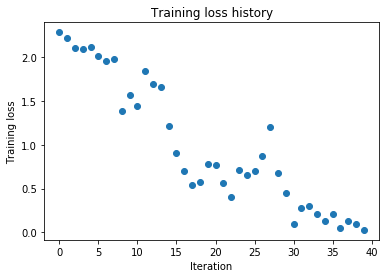

In [19]:
# TODO: Use a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale  = 1e-1  # Experiment with this!
learning_rate = 1e-3  # Experiment with this!

def params(lr: tuple, ws: tuple):
    """
    Generates random values for 
    learning rate and weight_scale
    
    params:
    lr: learning rate range tuple, -> (min, max)
    ws: weight scale range  tuple, -> (min, max)
    """
    learning_rate = np.power(10, np.random.uniform(lr[0], lr[1]))
    weight_scale  = np.power(10, np.random.uniform(ws[0], ws[1]))

    return learning_rate, weight_scale

best_train_accuracy = -1
best_solver = None
best_lr = None
best_ws = None

print("Overfitting with 5 Layers: ")

i = 0
while True:
    
    lr, ws = params(lr=(-2, 0), ws=(-2, -0))
    
    model = FullyConnectedNet([100, 100, 100, 100], weight_scale=ws, dtype=np.float64)
    
    solver = Solver(model, small_data,
                    print_every=-1, num_epochs=20, batch_size=25,
                    update_rule='sgd',
                    optim_config={
                      'learning_rate': lr,
                    },
                    verbose=False
             )
    
    solver.train()
    
    train_accuracy = solver.train_acc_history[-1]
    
    if train_accuracy > best_train_accuracy:
        best_train_accuracy = train_accuracy
        
        best_solver = solver
        best_lr = lr
        best_ws = ws
        
        print("↑", end="")
        print(f"[{i:03}] [Accuracy: {train_accuracy:.3f}] [lr: {lr:.10f}] [ws: {ws:.10f}]")
        
        if train_accuracy == 1.0:
            break
                            
    i += 1

    
print()
print(f"[Best] [Accuracy: {best_train_accuracy:.3f}] [lr: {best_lr:.10f}] [ws: {best_ws:.10f}]")
solver = best_solver

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

## Inline Question 2: 
Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net? In particular, based on your experience, which network seemed more sensitive to the initialization scale? Why do you think that is the case?

## Answer:
[FILL THIS IN]


# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent. See the Momentum Update section at http://cs231n.github.io/neural-networks-3/#sgd for more information.

Open the file `comp411/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than e-8.

In [20]:
from comp411.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


# SGD+NesterovMomentum
Stochastic gradient descent with Nesterov momentum is an optimized version of the SGD with plain momentum.
See the Nesterov Momentum section at http://cs231n.github.io/neural-networks-3/#sgd for more information.

Implement the SGD+Nesterov momentum update rule in the function `sgd_nesterov_momentum` and run the following to check your implementation. 
You should see errors less than e-8.

In [21]:
from comp411.optim import sgd_nesterov_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_nesterov_momentum(w, dw, config=config)

expected_next_w = np.asarray([
    [0.08714   , 0.15246105, 0.21778211, 0.28310316, 0.34842421],
    [0.41374526, 0.47906632, 0.54438737, 0.60970842, 0.67502947],
    [0.74035053, 0.80567158, 0.87099263, 0.93631368, 1.00163474],
    [1.06695579, 1.13227684, 1.19759789, 1.26291895, 1.32824   ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

# Should see relative errors around e-8 or less
print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  1.0875187099974104e-08
velocity error:  4.269287743278663e-09


Once you have done so, run the following to train a six-layer network with SGD, SGD+momentum, and SGD+Nesterov momentum.
You should see the SGD+momentum and SGD+Nesterov update rules converge faster than plain SGD.

running with  sgd

running with  sgd_momentum

running with  sgd_nesterov_momentum



/Users/firattamur/opt/anaconda3/envs/comp411-v2/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


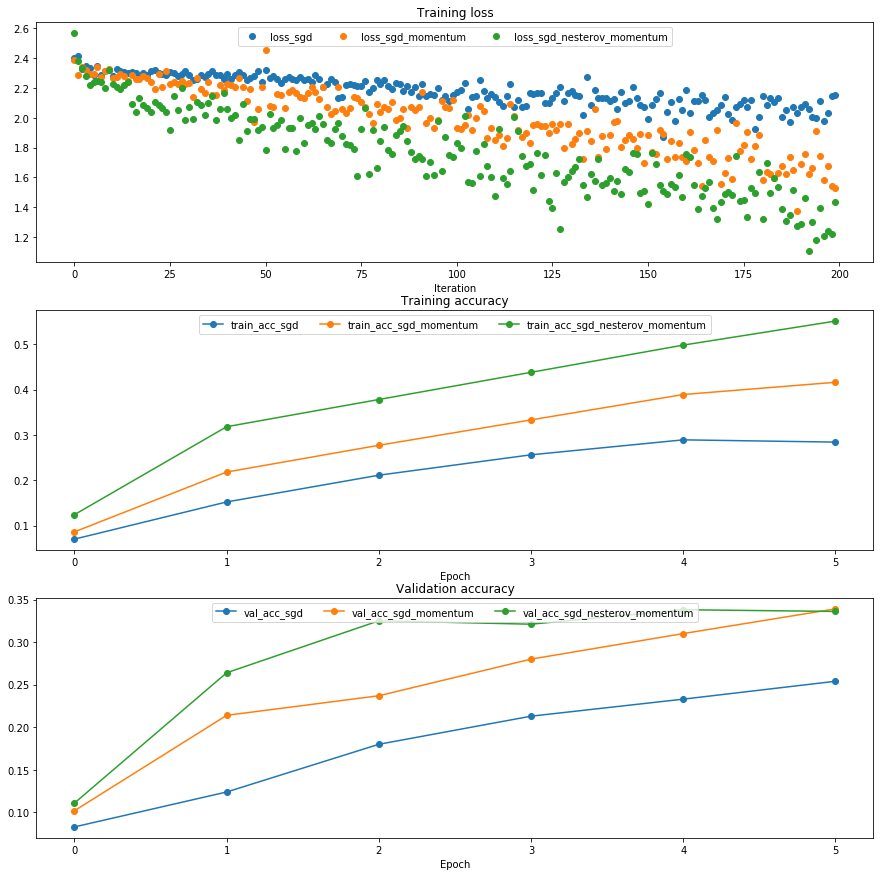

In [22]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum', 'sgd_nesterov_momentum']:
    print('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

    solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 5e-3,
                  },
                  verbose=False)
    solvers[update_rule] = solver
    solver.train()
    print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label="loss_%s" % update_rule)

    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label="train_acc_%s" % update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label="val_acc_%s" % update_rule)
    
for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
    
plt.gcf().set_size_inches(15, 15)
plt.show()

# RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `comp411/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

**NOTE:** Please implement the _complete_ Adam update rule (with the bias correction mechanism)

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).
    <br>RMSProp update formula: http://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.
    <br>Adam update formula: http://ruder.io/optimizing-gradient-descent/index.html#adam

In [23]:
# Test RMSProp implementation
from comp411.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

# You should see relative errors around e-7 or less
print("RMSProp test")
print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

RMSProp test
next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [24]:
# Test Adam implementation
from comp411.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

# You should see relative errors around e-7 or less
print("Adam test")
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

Adam test
next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

running with  adam

running with  rmsprop



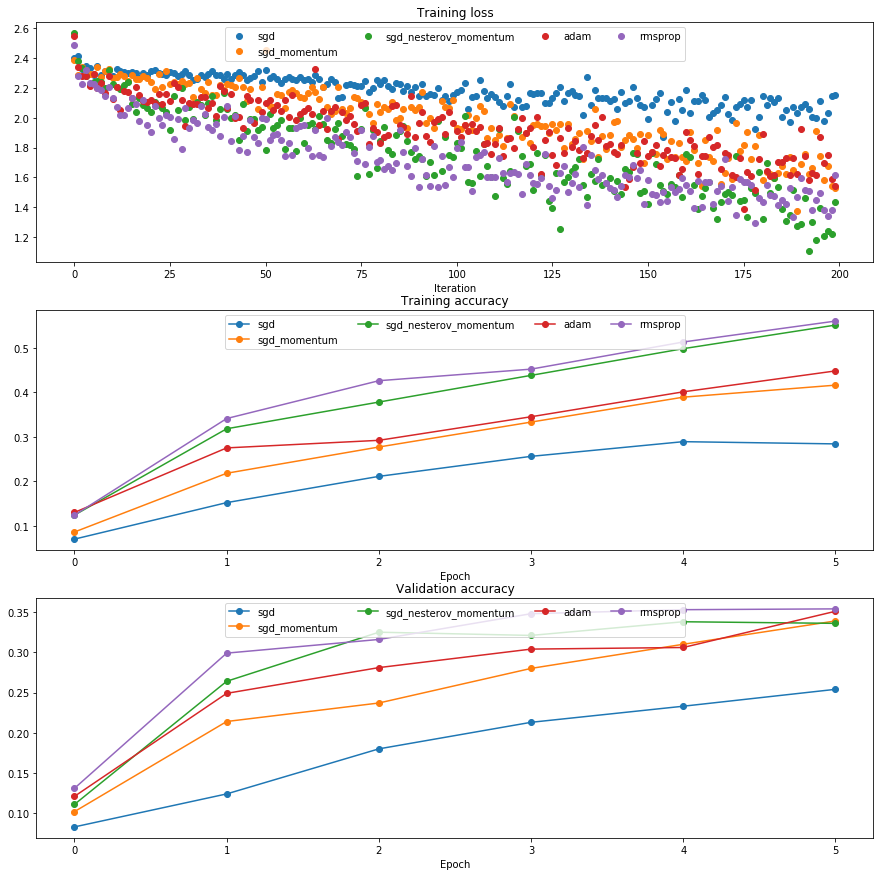

In [25]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}

for update_rule in ['adam', 'rmsprop']:
    print('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

    solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=False)
    solvers[update_rule] = solver
    solver.train()
    print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)

    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)
    
for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
    
plt.gcf().set_size_inches(15, 15)
plt.show()

# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

You might find it useful to complete the `Dropout.ipynb` notebook before completing this part, since this technique can 
help you train powerful models.

In [26]:
CIFAR_10_data = {
  'X_train': data['X_train'],
  'y_train': data['y_train'],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = None
weight_scale = None
best_model = None
solver = None

################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# find dropout useful. Store your best model in the best_model variable. #
#
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


def params(lr: tuple, ws: tuple, reg: tuple, hidden: tuple, layer: tuple):
    """
    Generates random values for 
    learning rate, regularization and hidden layer dimension.
    
    params:
    lr    : learning rate range:       tuple, -> (min, max)
    ws    : weight scale range         tuple, -> (min, max)
    reg   : regularization rate range: tuple, -> (min, max)
    hidden: hidden layer size range:   tuple, -> (min, max)
    layer : network layer count range: tuple, -> (min, max)
    """
    learning_rate  = np.power(10, np.random.uniform(lr[0], lr[1]))
    weight_scale   = np.power(10, np.random.uniform(ws[0], ws[1]))
    regularization = np.power(10, np.random.uniform(reg[0], reg[1]))
    layer_count    = np.random.randint(layer[0], layer[1])
    
    hiddens = []
    
    for i in range(layer_count):
        hiddens.append(np.random.randint(hidden[0], hidden[1]))
        
    return learning_rate, weight_scale, regularization, hiddens
        

best_lr = None
best_ws = None
best_reg = None
best_layer_count = None
best_hiddens = None
best_score = -1

i = 0
while True:
    
    lr, ws, reg, hiddens = params(lr=(-3, -1), ws=(-3, -1), reg=(-7, -4), hidden=(50, 200), layer=(1, 2))
        
    model = FullyConnectedNet(hiddens,
                    weight_scale=ws, reg=reg, dtype=np.float64)
    solver = Solver(model, CIFAR_10_data,
                    print_every=-1, num_epochs=10, batch_size=256,
                    update_rule='adam',
                    optim_config={
                      'learning_rate': lr,
                    },
                    verbose=False
             )
    
    solver.train()
    
    # get train and validation accuracy of network
    train_accuracy = solver.train_acc_history[-1]
    val_accuracy   = solver.best_val_acc
    
    if best_score < val_accuracy:
        best_score = val_accuracy
        
        # save best params
        best_lr = lr
        best_ws = ws
        best_reg = reg
        best_layer_count = len(hiddens)
        best_hiddens = hiddens
        best_solver  = solver
        best_model = model
    
        print("↑", end="")
        print(f"[{i}] [Accuracy: {val_accuracy:.3f}] [lr: {lr:.10f}] [reg: {reg:.10f}] [layer: {len(hiddens):02}] [Loss: {solver.loss_history[-1]:.3f}]")
        
        if best_score > 0.50:
            break
                        
    i += 1
        
print()
print(f"[Best] [Accuracy: {best_score:.3f}] [lr: {best_lr:.10f}] [reg: {best_reg:.10f}] [layer: {len(hiddens):02}] [Loss: {best_solver.loss_history[-1]:.3f}]")


solver = best_solver


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

↑[0] [Accuracy: 0.481] [lr: 0.0069851551] [reg: 0.0000111472] [layer: 01] [Loss: 1.410]
↑[2] [Accuracy: 0.521] [lr: 0.0085633692] [reg: 0.0000003757] [layer: 01] [Loss: 1.386]

[Best] [Accuracy: 0.521] [lr: 0.0085633692] [reg: 0.0000003757] [layer: 01] [Loss: 1.386]


# Test your model!
Run your best model on the validation and test sets. You should achieve above 50% accuracy on the validation set.

In [27]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.521
Test set accuracy:  0.476
